In [6]:
from matplotlib import pyplot as plt
import audiofile
import numpy as np

In [7]:
from rVADfast import rVADfast

In [8]:
from glob import glob
import re

def get_alignment(alignment_root, identifiers):
    speaker = str(identifiers[0])
    chapter = str(identifiers[1])
    utterance = str(identifiers[2])
    # Make sure utterance id is four digits
    utterance = f"{utterance:0>4}"

    alignment_identifier = '-'.join((speaker, chapter, utterance))

    path = alignment_root + speaker + "/" + chapter + "/"
    alignment_file = glob(path + "*alignment.txt")[0]
    with open(alignment_file, encoding="utf8") as file:
        timestamps = None
        for line in file.readlines():
            if alignment_identifier in line:
                aligned_text = line.split(' ')[1][1:-1]
                timestamps = line.split(' ')[2][1:-2]  # remove newline
                timestamps = timestamps.split(',')
                timestamps = np.array([float(timestamp) for timestamp in timestamps])
                labels = re.sub(r"[A-Z']+", 'W', aligned_text)  # we only need word or no word ("W", "")
                labels = np.char.array(labels.split(","), itemsize=4)
                break

        if timestamps is None:
            print(f"No alignment found for {alignment_identifier}")

    return timestamps, labels


def interpolate_labels(timestamps_interp, label_timestamps, labels):
    previous_index = 0
    labels_interp = np.zeros_like(timestamps_interp)
    for label, timestamp in zip(labels, label_timestamps):
        index = np.searchsorted(timestamps_interp, timestamp)
        labels_interp[previous_index:index] = label
        previous_index = index
    return labels_interp


In [9]:
signal, sampling_rate = audiofile.read("/Users/JG96XG/Desktop/data_sets/LibriSpeech/train-clean-100/8629/261140/8629-261140-0001.flac")

identifiers = "8629-261140-0001".split("-")

timestamps, labels = get_alignment(alignment_root="/Users/JG96XG/Desktop/data_sets/LibriSpeech-Alignments/train-clean-100/", identifiers=identifiers)

labels = (labels=="W").astype(int)

signal_timestamps = np.arange(signal.shape[-1]) / sampling_rate

labels = interpolate_labels(signal_timestamps, timestamps, labels)

rVAD_labels, rVAD_timestamps = rVADfast.rVADfast(signal, sampling_rate)

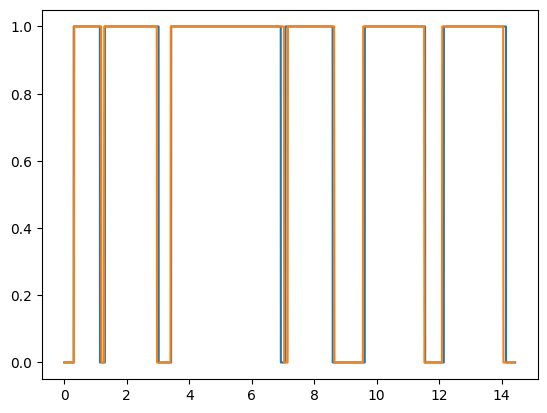

In [10]:
plt.plot(signal_timestamps, labels)
plt.plot(rVAD_timestamps, rVAD_labels)